In [1]:
import torch
import torch_geometric as pyg
import numpy as np
import  data_transform
import importlib
importlib.reload(data_transform)
from data_transform import get_data
import baseline
importlib.reload(baseline)
import  cgvae
importlib.reload(cgvae)

from IPython.display import display, HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

/Users/cgu3/anaconda3/envs/cgvae/lib/python3.10/site-packages/torch_geometric/typing.py:63: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/cgu3/anaconda3/envs/cgvae/lib/python3.10/site-packages/torch_scatter/_version_cpu.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <149E82FB-0365-32E3-985A-BC7861332A5F> /Users/cgu3/anaconda3/envs/cgvae/lib/python3.10/site-packages/torch_scatter/_version_cpu.so
  Expected in:     <F19B5356-08DC-327C-8EE1-6C5127508CD0> /Users/cgu3/anaconda3/envs/cgvae/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/cgu3/anaconda3/envs/cgvae/lib/python3.10/site-packages/torch_geometric/typing.py:101: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: dlopen(/Users/cgu3/anaconda3/envs/cgvae/lib/python3.10/site-packages/torch_sparse/_version_cp

In [2]:
# open ipython terminal
%qtconsole

In [3]:
from torch_geometric.datasets import KarateClub
# dataset = KarateClub()

In [4]:
# data = dataset[0]

In [5]:
# data.x

In [73]:
SPLIT_RATIO = 0.05
# dataloader, dataset_size = get_data('../data', 'KarateClub', ratio=0.5, neg_edge_ratio=1.0)
dataloader, dataset_size = get_data('../data', 'Cora', ratio=SPLIT_RATIO)

In [74]:
data = next(iter(dataloader))

In [86]:
dim = data['input'].x.shape[0]
split = int(dim * SPLIT_RATIO)

In [87]:
# create graph from edge_index
import networkx as nx
input_graph = pyg.utils.to_networkx(data['input'])
output_graph = pyg.utils.to_networkx(data['output'])

In [88]:
path = dict(nx.shortest_path_length(input_graph))

In [92]:
# add edge between A and B if the distance between A and B is less than 3 with probability 0.5

expanded_input_graph = input_graph

for i in range(dim):
    for j in range(dim):
        # if  key-pair exists
        if path.get(i) is not None and path[i].get(j) is not None:
            if i != j and path[i][j]  == 2:
                if np.random.rand() < 0.1:
                    expanded_input_graph.add_edge(i, j)
            
            if i != j and path[i][j] == 3:
                if np.random.rand() < 0.01:
                    expanded_input_graph.add_edge(i, j)

# make sure the graph is undirected
expanded_input_graph = expanded_input_graph.to_undirected()

In [93]:
# plot the graph adjacency matrix
import matplotlib.pyplot as plt


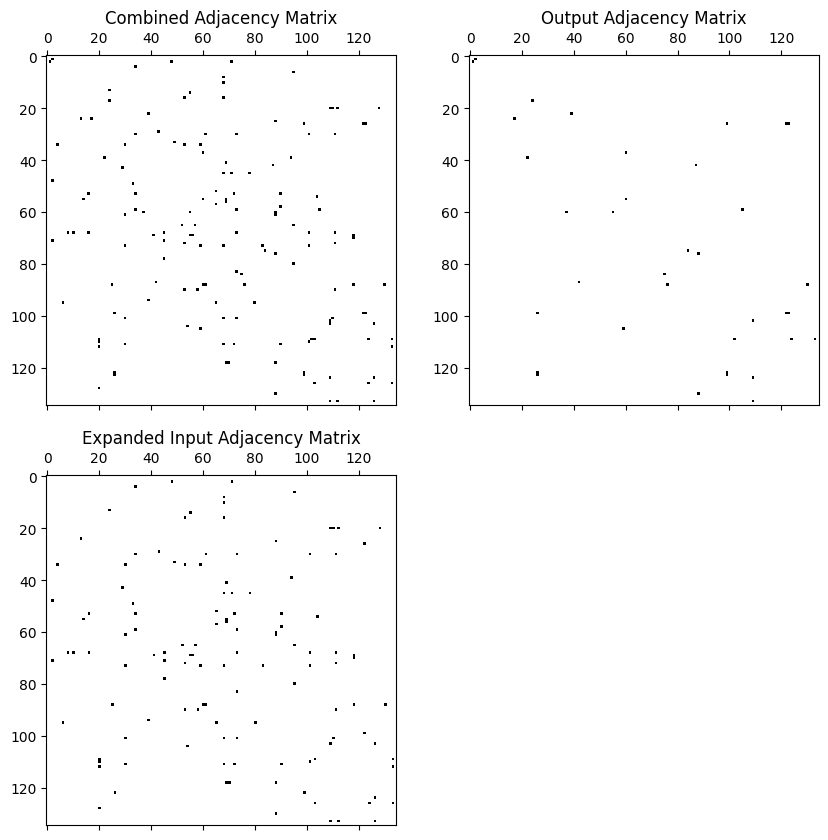

In [94]:
import matplotlib.pyplot as plt
import numpy as np

# Convert the adjacency matrices to dense format
expanded_input_adj_matrix_dense = np.array(nx.adjacency_matrix(expanded_input_graph).todense())
output_adjacency_matrix_dense = np.array(nx.adjacency_matrix(output_graph).todense())

# Create a combined adjacency matrix
combined_adj_matrix = expanded_input_adj_matrix_dense + output_adjacency_matrix_dense

# Reassign value 1 if the value is greater than 1
combined_adj_matrix[combined_adj_matrix > 1] = 1

# Create a new figure
plt.figure(figsize=(10, 10))

# Plot the output adjacency matrix
plt.subplot(2, 2, 2)
plt.title('Output Adjacency Matrix')
plt.matshow(output_adjacency_matrix_dense[:split, :split], cmap='Greys', fignum=False)

# Plot the combined adjacency matrix
plt.subplot(2, 2, 1)
plt.title('Combined Adjacency Matrix')
plt.matshow(combined_adj_matrix[:split, :split], cmap='Greys', fignum=False)

plt.subplot(2, 2, 3)
plt.title('Expanded Input Adjacency Matrix')
plt.matshow(expanded_input_adj_matrix_dense[:split, :split],  cmap='Greys', fignum=False)

# Display the plots
plt.show()

In [81]:
# # remove standalone pixels
# from scipy import ndimage
# erosion = ndimage.binary_erosion(expanded_input_adj_matrix_dense[:split, :split], structure=np.eye(2)).astype(int)
# plt.matshow(erosion, cmap='Greys')

In [82]:
# get length of the adjacency matrix
combined_adj_matrix = combined_adj_matrix
dim = combined_adj_matrix.shape[0]
mask = np.ones((dim, dim), dtype=bool)
mask[:  int(dim / 2) ,:int(dim  /2)] = 0
combined_adj_matrix[mask] = 0

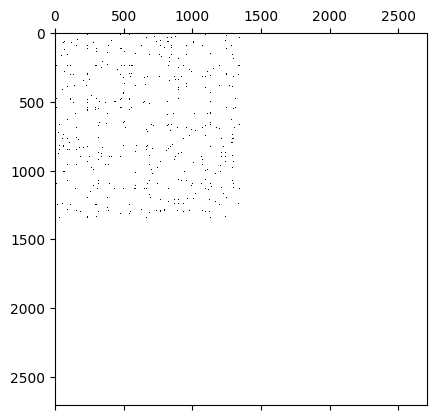

In [83]:
plt.matshow(combined_adj_matrix, cmap='Greys')

In [84]:
# get the input adjacency matrix
input_graph = pyg.utils.to_networkx(data['input'])
input_adj_matrix = nx.adjacency_matrix(input_graph)

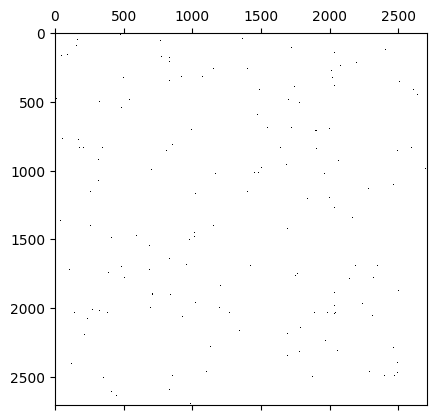

In [85]:
plt.matshow(input_adj_matrix.todense(), cmap='Greys')

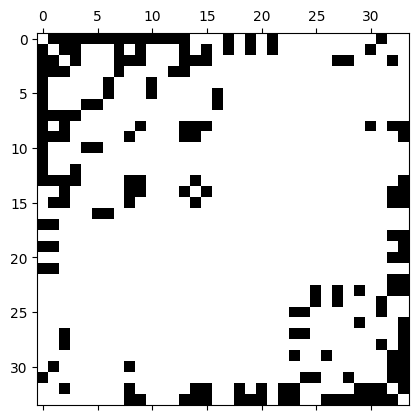

In [319]:
input_combined_adj_matrix = combined_adj_matrix + input_adj_matrix.todense()
plt.matshow(input_combined_adj_matrix, cmap='Greys')

In [327]:
# generate permutation matrix
np.random.seed(0)
perm = np.eye(dim, dtype=int)
np.random.shuffle(perm)

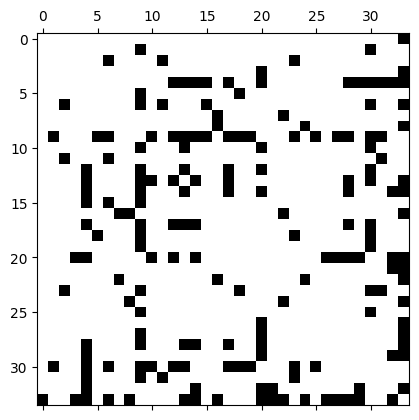

In [328]:
# use permutation matrix to shuffle the adjacency matrix input_combined_adj_matrix
shuffled_combined_adj_matrix = perm @ input_combined_adj_matrix @ perm.T
plt.matshow(shuffled_combined_adj_matrix, cmap='Greys')

In [ ]:
# todo: how to regularize the total number of edges in the adjacency matrix